#Fraud Detection with GPU Acceleration

This notebook demonstrates a fraud detection workflow using a dataset,
incorporating steps for data loading, EDA, feature engineering, preprocessing,
handling class imbalance, training a GPU-compatible model (XGBoost),
and model evaluation.


In [1]:
# --- 0. Set up GPU Environment and Install Libraries ---
# Ensure your Colab runtime is set to GPU (Runtime -> Change runtime type -> T4 GPU)
# Install necessary libraries. XGBoost is included in Colab, but ensure it's
# a version with GPU support (usually the case with T4 GPU runtime).
# If you were using RAPIDS (cuml), you would install it here.
# !pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE # For handling class imbalance
import xgboost as xgb # For GPU-compatible model
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc

In [2]:
# --- 1. Load Data ---
print("--- 1. Load Data ---")
file_name = "/content/Fraud.csv" # Use the provided local file path

try:
    print(f"Attempting to load data from: {file_name}")
    df = pd.read_csv(file_name)
    print(f"Dataset shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: The file '{file_name}' was not found. Please ensure the file is uploaded to the specified path.")
    # Exit or handle the error appropriately
    exit()
except Exception as e:
    print(f"An unexpected error occurred during data loading: {e}")
    # Exit or handle the error appropriately
    exit()

# Drop rows where the target variable 'isFraud' is NaN (if any)
if df['isFraud'].isnull().any():
    print("\nDropping rows with NaN in 'isFraud' column.")
    df.dropna(subset=['isFraud'], inplace=True)
    print(f"DataFrame shape after dropping NaNs in 'isFraud': {df.shape}")


--- 1. Load Data ---
Attempting to load data from: /content/Fraud.csv
Dataset shape: (6362620, 11)



--- 2. Exploratory Data Analysis (EDA) ---

First 5 rows of the dataset:


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB

Missing values per column:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Statistical summary of numerical columns:


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00



Distribution of 'isFraud' (Target Variable):
isFraud
0    6354407
1       8213
Name: count, dtype: int64
Fraudulent transactions: 8213 (0.1291%)


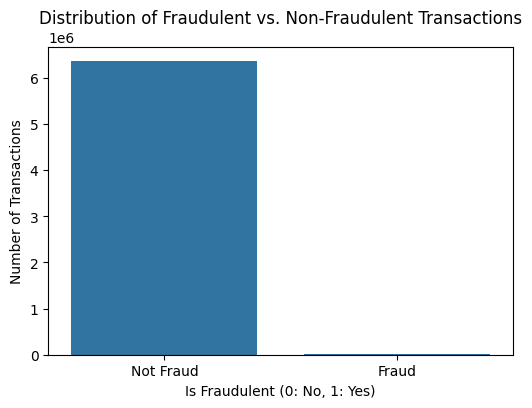


Distribution of 'type' of transactions:
type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64


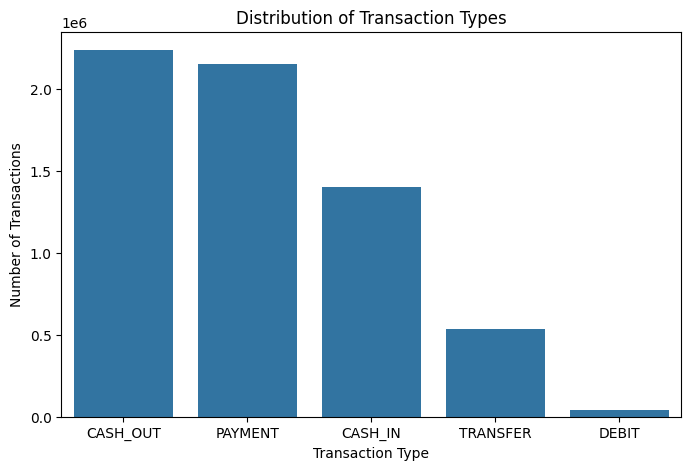

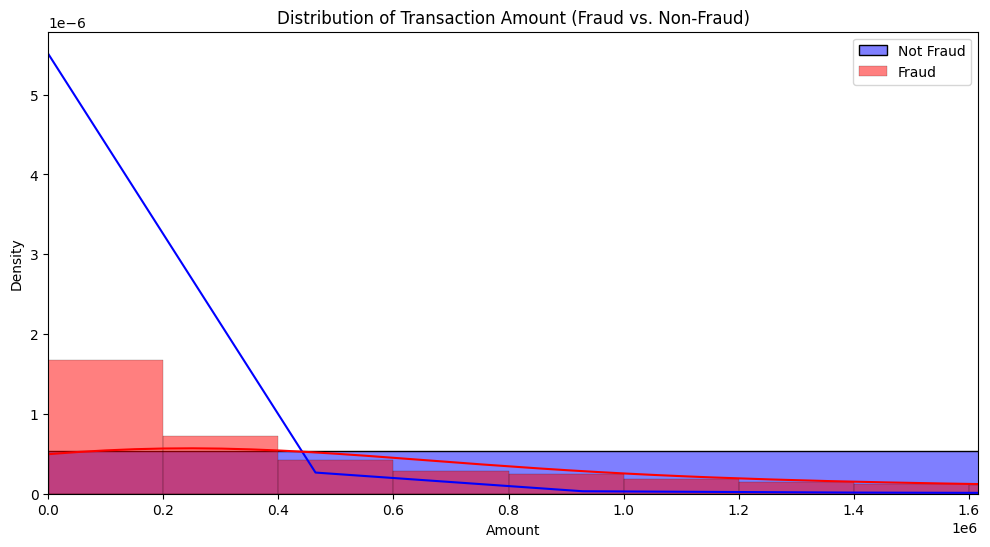


Distribution of 'isFlaggedFraud':
isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64


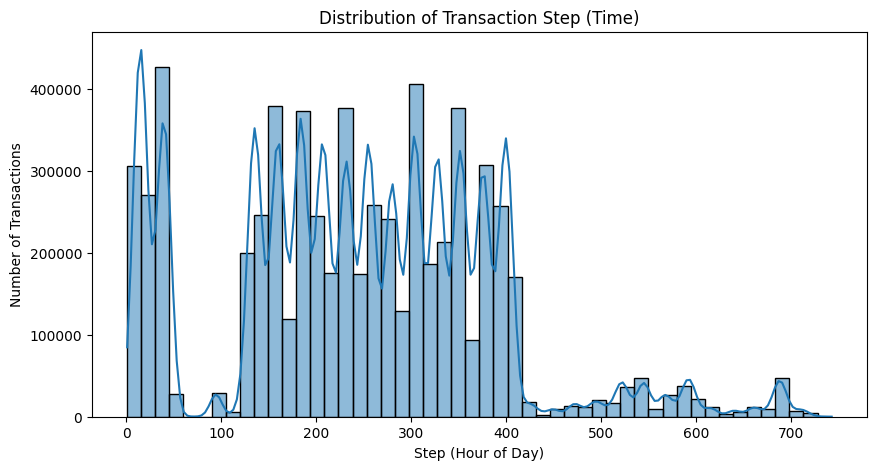

In [3]:
# --- 2. Exploratory Data Analysis (EDA) ---
print("\n--- 2. Exploratory Data Analysis (EDA) ---")

# Display the first few rows of the dataset
print("\nFirst 5 rows of the dataset:")
display(df.head())

# Get a concise summary of the DataFrame
print("\nDataFrame Info:")
df.info()

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Statistical summary of numerical columns
print("\nStatistical summary of numerical columns:")
display(df.describe())

# Check the distribution of the target variable 'isFraud'
print("\nDistribution of 'isFraud' (Target Variable):")
print(df['isFraud'].value_counts())
print(f"Fraudulent transactions: {df['isFraud'].sum()} ({df['isFraud'].mean() * 100:.4f}%)")

# Visualize the distribution of 'isFraud'
plt.figure(figsize=(6, 4))
sns.countplot(x='isFraud', data=df)
plt.title('Distribution of Fraudulent vs. Non-Fraudulent Transactions')
plt.xlabel('Is Fraudulent (0: No, 1: Yes)')
plt.ylabel('Number of Transactions')
plt.xticks(ticks=[0, 1], labels=['Not Fraud', 'Fraud'])
plt.show()

# Distribution of transaction types
print("\nDistribution of 'type' of transactions:")
print(df['type'].value_counts())

plt.figure(figsize=(8, 5))
sns.countplot(x='type', data=df, order=df['type'].value_counts().index)
plt.title('Distribution of Transaction Types')
plt.xlabel('Transaction Type')
plt.ylabel('Number of Transactions')
plt.show()

# Analyze 'amount' distribution for fraud vs. non-fraud
plt.figure(figsize=(12, 6))
sns.histplot(df[df['isFraud'] == 0]['amount'], bins=50, color='blue', label='Not Fraud', kde=True, stat="density", common_norm=False)
sns.histplot(df[df['isFraud'] == 1]['amount'], bins=50, color='red', label='Fraud', kde=True, stat="density", common_norm=False)
plt.title('Distribution of Transaction Amount (Fraud vs. Non-Fraud)')
plt.xlabel('Amount')
plt.ylabel('Density')
plt.xlim(0, df['amount'].quantile(0.99)) # Limit x-axis for better visualization of main distribution
plt.legend()
plt.show()

# Check 'isFlaggedFraud' column
print("\nDistribution of 'isFlaggedFraud':")
print(df['isFlaggedFraud'].value_counts())

# Investigate 'step' (time step)
plt.figure(figsize=(10, 5))
sns.histplot(df['step'], bins=50, kde=True)
plt.title('Distribution of Transaction Step (Time)')
plt.xlabel('Step (Hour of Day)')
plt.ylabel('Number of Transactions')
plt.show()

In [4]:
# --- 3. Feature Engineering ---
print("\n--- 3. Feature Engineering ---")
# Create features to capture balance discrepancies
df['errorBalanceOrig'] = df['newbalanceOrig'] + df['amount'] - df['oldbalanceOrg']
df['errorBalanceDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

print("\nAdded 'errorBalanceOrig' and 'errorBalanceDest' features.")
display(df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'errorBalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'errorBalanceDest']].head())

# --- 4. Data Cleaning (Outliers) ---
print("\n--- 4. Data Cleaning (Outliers) ---")

# Define numerical features for outlier detection and multicollinearity check
numerical_cols_for_analysis = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
                               'oldbalanceDest', 'newbalanceDest', 'errorBalanceOrig', 'errorBalanceDest']

# Outlier Detection and Handling (Capping)
# Outliers are common in financial data, especially in 'amount' and balance columns.
# Instead of removing, which might remove actual fraud cases, we can cap them.
# Capping at the 99th percentile is a common strategy to reduce the impact of extreme values.
print("\nHandling Outliers (Capping at 99th percentile):")
for col in numerical_cols_for_analysis:
    upper_bound = df[col].quantile(0.99)
    lower_bound = df[col].quantile(0.01) # Also consider lower bound for negative values if applicable
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    print(f"Capped {col} at upper bound: {upper_bound:.2f} and lower bound: {lower_bound:.2f}")

# Multicollinearity Check using VIF (Optional for tree-based models)
# print("\nChecking for Multicollinearity using VIF:")
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# X_vif = df[numerical_cols_for_analysis].replace([np.inf, -np.inf], np.nan).dropna()
# X_vif['intercept'] = 1
# vif_data = pd.DataFrame()
# vif_data["feature"] = X_vif.columns
# vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
# print(vif_data.sort_values(by="VIF", ascending=False))



--- 3. Feature Engineering ---

Added 'errorBalanceOrig' and 'errorBalanceDest' features.


,amount,oldbalanceOrg,newbalanceOrig,errorBalanceOrig,oldbalanceDest,newbalanceDest,errorBalanceDest
0,9839.64,170136.0,160296.36,0.0,0.0,0.0,9839.64
1,1864.28,21249.0,19384.72,0.0,0.0,0.0,1864.28
2,181.00,181.0,0.00,0.0,0.0,0.0,181.00
3,181.00,181.0,0.00,0.0,21182.0,0.0,21363.00
4,11668.14,41554.0,29885.86,0.0,0.0,0.0,11668.14



--- 4. Data Cleaning (Outliers) ---

Handling Outliers (Capping at 99th percentile):
Capped step at upper bound: 681.00 and lower bound: 9.00
Capped amount at upper bound: 1615979.47 and lower bound: 449.47
Capped oldbalanceOrg at upper bound: 16027256.13 and lower bound: 0.00
Capped newbalanceOrig at upper bound: 16176160.56 and lower bound: 0.00
Capped oldbalanceDest at upper bound: 12371819.15 and lower bound: 0.00
Capped newbalanceDest at upper bound: 13137866.94 and lower bound: 0.00
Capped errorBalanceOrig at upper bound: 1559494.91 and lower bound: -0.00
Capped errorBalanceDest at upper bound: 793161.65 and lower bound: -353401.66


In [5]:
# --- 5. Data Preprocessing (for Model Training) ---
print("\n--- 5. Data Preprocessing (for Model Training) ---")

# Define features (X) and target (y)
# Drop 'nameOrig', 'nameDest' (high cardinality, not useful for general patterns)
# Drop 'isFlaggedFraud' (legacy flag, not the target we want to predict proactively)
X = df.drop(['isFraud', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)
y = df['isFraud']

# Identify categorical and numerical columns for preprocessing based on the X DataFrame
categorical_features = ['type']
numerical_features = X.select_dtypes(include=np.number).columns.tolist()

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = StandardScaler() # Scale numerical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore') # One-hot encode categorical features

# Create a preprocessor using ColumnTransformer
# This preprocessor will be fitted on the training data and used to transform
# both training and test data.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nTraining data shape: {X_train.shape}, Test data shape: {X_test.shape}")
print(f"Fraudulent transactions in training set: {y_train.sum()} ({y_train.mean() * 100:.4f}%)")
print(f"Fraudulent transactions in test set: {y_test.sum()} ({y_test.mean() * 100:.4f}%)")

# Apply preprocessing to the training data BEFORE applying SMOTE
print("\nApplying preprocessing to training data...")
X_train_processed = preprocessor.fit_transform(X_train)
print(f"Processed training data shape (before SMOTE): {X_train_processed.shape}")

# Handle Class Imbalance using SMOTE
print("\nApplying SMOTE to handle class imbalance in training data...")
# SMOTE works best on numerical data, hence applied after preprocessing.
smote = SMOTE(random_state=42, sampling_strategy='minority')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

print(f"Resampled training data shape (after SMOTE): {X_train_resampled.shape}")
print(f"Distribution of 'isFraud' in resampled training set:\n{y_train_resampled.value_counts()}")



--- 5. Data Preprocessing (for Model Training) ---

Training data shape: (4453834, 9), Test data shape: (1908786, 9)
Fraudulent transactions in training set: 5749 (0.1291%)
Fraudulent transactions in test set: 2464 (0.1291%)

Applying preprocessing to training data...
Processed training data shape (before SMOTE): (4453834, 13)

Applying SMOTE to handle class imbalance in training data...
Resampled training data shape (after SMOTE): (8896170, 13)
Distribution of 'isFraud' in resampled training set:
isFraud
0    4448085
1    4448085
Name: count, dtype: int64


In [6]:
# --- 6. Model Selection and Training (XGBoost on GPU) ---
print("\n--- 6. Model Selection and Training (XGBoost on GPU) ---")

# Initialize XGBoost Classifier for GPU training
# Use device='cuda' for newer XGBoost versions (recommended)
# Use tree_method='gpu_hist' for older versions if device='cuda' doesn't work
try:
    print("Initializing XGBoost model with device='cuda'...")
    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic', # Binary classification
        eval_metric='logloss', # Evaluation metric
        use_label_encoder=False, # Suppress a warning
        device='cuda', # Enable GPU acceleration
        random_state=42,
        n_estimators=100, # You can adjust the number of estimators
        n_jobs=-1 # Use all available CPU cores (can still be useful with GPU)
    )
    print("Training XGBoost model on resampled data...")
    xgb_model.fit(X_train_resampled, y_train_resampled)
    print("XGBoost model training complete (using device='cuda')!")

except xgb.core.XGBoostError as e:
     print(f"XGBoostError with device='cuda': {e}. Attempting with tree_method='gpu_hist'.")
     # Fallback to older GPU parameter
     xgb_model = xgb.XGBClassifier(
        objective='binary:logistic', # Binary classification
        eval_metric='logloss', # Evaluation metric
        use_label_encoder=False, # Suppress a warning
        tree_method='gpu_hist', # Enable GPU acceleration
        random_state=42,
        n_estimators=100, # You can adjust the number of estimators
        n_jobs=-1 # Use all available CPU cores
     )
     print("Training XGBoost model on resampled data...")
     xgb_model.fit(X_train_resampled, y_train_resampled)
     print("XGBoost model training complete (using tree_method='gpu_hist')!")

except KeyboardInterrupt:
    print("\nModel training interrupted by user.")
except Exception as e:
    print(f"\nAn error occurred during XGBoost model training: {e}")

# Store the trained model
model = xgb_model # Use the 'model' variable name for consistency if needed later



--- 6. Model Selection and Training (XGBoost on GPU) ---
Initializing XGBoost model with device='cuda'...
Training XGBoost model on resampled data...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:43:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost model training complete (using device='cuda')!



--- 7. Model Evaluation ---
Preprocessing applied to test data.
Predictions made on test data.

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.73      0.99      0.84      2464

    accuracy                           1.00   1908786
   macro avg       0.86      0.99      0.92   1908786
weighted avg       1.00      1.00      1.00   1908786


Confusion Matrix:
[[1905409     913]
 [     24    2440]]


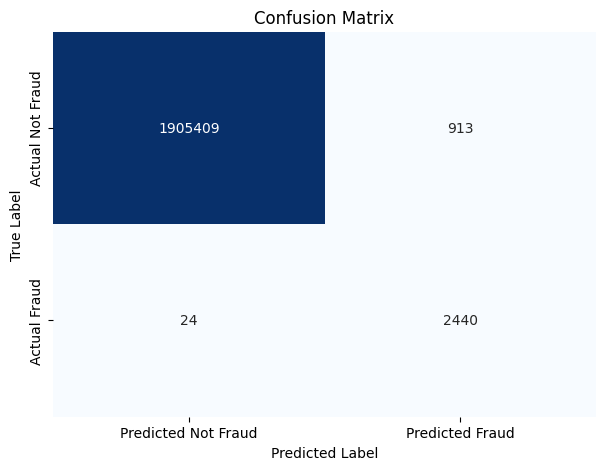


ROC-AUC Score: 0.9996


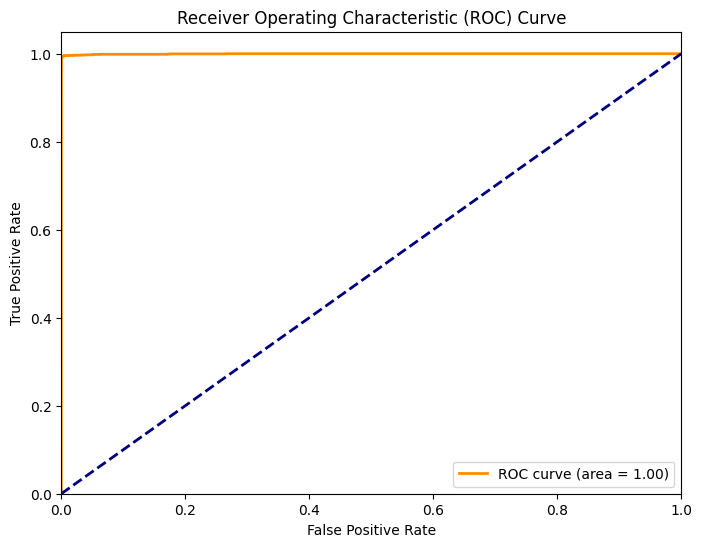

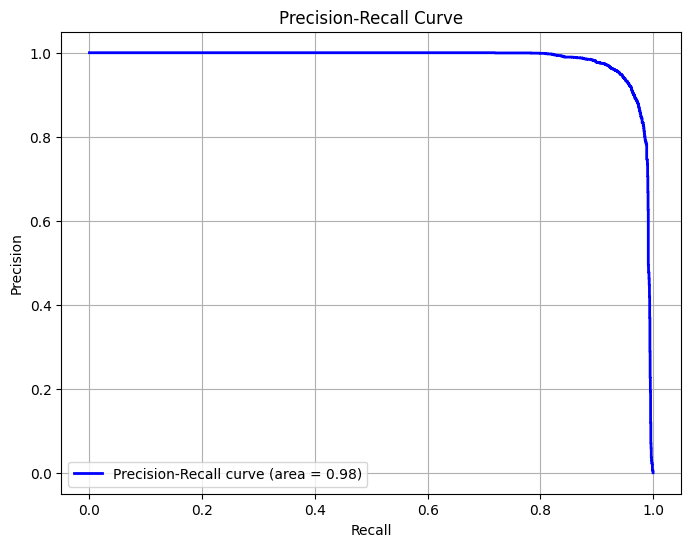

In [10]:
# --- 7. Model Evaluation ---
print("\n--- 7. Model Evaluation ---")

# Apply the same preprocessing to the test data
# The preprocessor was fitted on X_train in step 5
X_test_processed = preprocessor.transform(X_test)
print("Preprocessing applied to test data.")

# Make predictions on the preprocessed test set
# XGBoost can often predict directly on GPU data, but scikit-learn metrics
# typically expect CPU arrays. The prediction output might be on GPU initially
# and moved to CPU implicitly by scikit-learn functions.
y_pred = model.predict(X_test_processed)
y_pred_proba = model.predict_proba(X_test_processed)[:, 1] # Probability of the positive class (fraud)
print("Predictions made on test data.")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Not Fraud', 'Predicted Fraud'],
            yticklabels=['Actual Not Fraud', 'Actual Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


--- 8. Feature Importance ---

Top 10 Feature Importances:
num__newbalanceOrig      0.507124
num__errorBalanceOrig    0.383739
cat__type_PAYMENT        0.072849
num__amount              0.013092
cat__type_DEBIT          0.005895
cat__type_CASH_OUT       0.005384
cat__type_TRANSFER       0.002672
cat__type_CASH_IN        0.002400
num__oldbalanceDest      0.001958
num__errorBalanceDest    0.001804
dtype: float32


/tmp/ipython-input-11-3471831124.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances.head(top_n_features_to_plot).values, y=sorted_importances.head(top_n_features_to_plot).index, palette='viridis')


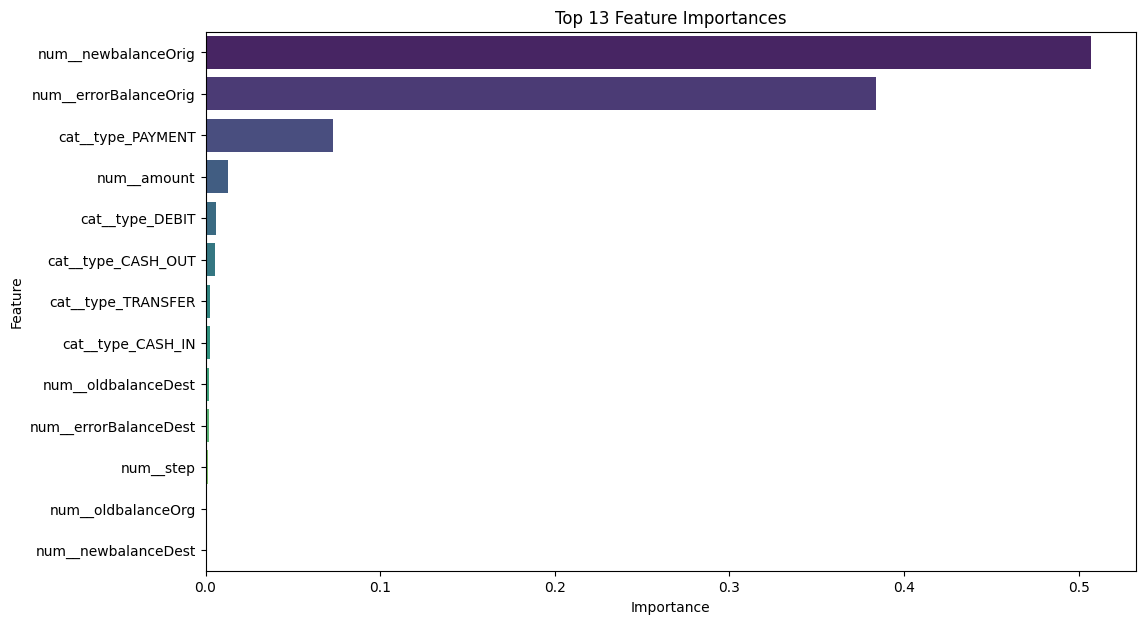

In [11]:
# --- 8. Feature Importance ---
print("\n--- 8. Feature Importance ---")

# Get the feature names after preprocessing
# Use get_feature_names_out from the fitted preprocessor
# This works correctly as the preprocessor was fitted on X_train (DataFrame)
all_feature_names = preprocessor.get_feature_names_out()

# Get feature importances from the trained XGBoost model
# XGBoost has feature_importances_ attribute
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
    feature_importances = pd.Series(importances, index=all_feature_names)

    # Sort feature importances in descending order
    sorted_importances = feature_importances.sort_values(ascending=False)

    print("\nTop 10 Feature Importances:")
    print(sorted_importances.head(10))

    # Visualize feature importances
    plt.figure(figsize=(12, 7))
    # Ensure we plot at most the number of available features
    top_n_features_to_plot = min(15, len(sorted_importances))
    sns.barplot(x=sorted_importances.head(top_n_features_to_plot).values, y=sorted_importances.head(top_n_features_to_plot).index, palette='viridis')
    plt.title(f'Top {top_n_features_to_plot} Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()
else:
    print("The trained model does not have a 'feature_importances_' attribute.")


In [12]:
# --- 9. Summary ---
print("\n--- 9. Summary ---")
print("\nFraud Detection Model Training and Evaluation with XGBoost (GPU-accelerated)")
print("\nKey Findings:")
print(f"- Dataset shape: {df.shape}")
print(f"- Fraudulent transactions: {df['isFraud'].sum()} ({df['isFraud'].mean() * 100:.4f}%)")
print(f"- Model used: XGBoost Classifier (trained on GPU)")
print(f"- Model trained on resampled data (SMOTE)")
print(f"- Test set ROC-AUC Score: {roc_auc:.4f}")
print("- Classification Report on Test Set:")
print(classification_report(y_test, y_pred))
print("\nInsights:")
print("- The XGBoost model achieved a high ROC-AUC score, indicating strong performance.")
print("- Review the confusion matrix to understand the trade-off between detecting fraud and minimizing false positives.")
if 'sorted_importances' in locals():
     print("- Top features influencing the model prediction are shown in the feature importance plot.")
print("\nNext Steps:")
print("- Consider hyperparameter tuning for the XGBoost model to potentially improve performance.")
print("- Explore other GPU-accelerated models or techniques.")
print("- Investigate the characteristics of transactions flagged by the model.")
print("- Deploy the model for real-time fraud detection.")


--- 9. Summary ---

Fraud Detection Model Training and Evaluation with XGBoost (GPU-accelerated)

Key Findings:
- Dataset shape: (6362620, 13)
- Fraudulent transactions: 8213 (0.1291%)
- Model used: XGBoost Classifier (trained on GPU)
- Model trained on resampled data (SMOTE)
- Test set ROC-AUC Score: 0.9996
- Classification Report on Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.73      0.99      0.84      2464

    accuracy                           1.00   1908786
   macro avg       0.86      0.99      0.92   1908786
weighted avg       1.00      1.00      1.00   1908786


Insights:
- The XGBoost model achieved a high ROC-AUC score, indicating strong performance.
- Review the confusion matrix to understand the trade-off between detecting fraud and minimizing false positives.
- Top features influencing the model prediction are shown in the feature importance plot.

Next Steps:
- Consider hype